In [1]:
%matplotlib inline

In [ ]:
TARGET_PATH = '/User/mlrun/lightgbm'

# convert a lightgbm model to onnx

In this notebook we will look at creating a component that converts lightgbm models to the ONNX format.  We will use the model created in the **[MLRun LightGBM demo](https://github.com/yjb-ds/demos/tree/master/lightgbm#instructions-for-lightgbm-demo)**.  The model was serialized as **/User/mlrun/lightgbm/lightgbm.model.pkl**.  If you haven't run that demonstration please do so now. Alternatively, you can modifiy the code below if you have your own serialized lightgbm model and some test data.

### function requirements
The following packages need to be installed before using this notebook the first time:

    import os
    os.environ['ONNX_ML'] = '1'

    !pip install -U -q onnxruntime
    !pip install -U -q git+https://github.com/microsoft/onnxconverter-common
    !pip install -U -q git+https://github.com/onnx/onnxmltools
    !pip install -U -q pydot

### imports

In [7]:
import os
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [8]:
import onnxruntime as rt

from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
from onnxmltools.convert.lightgbm.operator_converters.LightGbm import convert_lightgbm  # noqa
import onnxmltools.convert.common.data_types

from skl2onnx import convert_sklearn, update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes  # noqa
from skl2onnx.common.data_types import FloatTensorType

In [2]:
data = load_iris()
X = data.data[:, :2]
y = data.target

ind = numpy.arange(X.shape[0])
numpy.random.shuffle(ind)
X = X[ind, :].copy()
y = y[ind].copy()

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lgbm', LGBMClassifier(n_estimators=3))])
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lgbm',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=3, n_jobs=-1,
                                num_leaves=31, objective=None,
                                random_state=None, reg_alpha=0.0,
                                reg_lambda=0.0, silent=True, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

Register the converter for LGBMClassifier
+++++++++++++++++++++++++++++++++++++++++

The converter is implemented in *onnxmltools*:
`onnxmltools...LightGbm.py
<https://github.com/onnx/onnxmltools/blob/master/onnxmltools/convert/
lightgbm/operator_converters/LightGbm.py>`_.
and the shape calculator:
`onnxmltools...Classifier.py
<https://github.com/onnx/onnxmltools/blob/master/onnxmltools/convert/
lightgbm/shape_calculators/Classifier.py>`_.



Then we import the converter and shape calculator.



Let's register the new converter.



In [3]:
update_registered_converter(LGBMClassifier, 'LightGbmLGBMClassifier',
                            calculate_linear_classifier_output_shapes,
                            convert_lightgbm)

Convert again
+++++++++++++



In [4]:
model_onnx = convert_sklearn(pipe, 'pipeline_lightgbm',
                             [('input', FloatTensorType([None, 2]))])

# And save.
with open("pipeline_lightgbm.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

Compare the predictions
+++++++++++++++++++++++

Predictions with LightGbm.



In [5]:
print("predict", pipe.predict(X[:5]))
print("predict_proba", pipe.predict_proba(X[:1]))

predict [0 1 1 1 0]
predict_proba [[0.43837826 0.28095144 0.28067031]]


Predictions with onnxruntime.



In [6]:
sess = rt.InferenceSession("pipeline_lightgbm.onnx")
pred_onx = sess.run(None, {"input": X[:5].astype(numpy.float32)})
print("predict", pred_onx[0])
print("predict_proba", pred_onx[1][:1])

predict [0 1 1 1 0]
predict_proba [[0.43837824 0.28095144 0.2806703 ]]


Display the ONNX graph
++++++++++++++++++++++



(-0.5, 2578.5, 2558.5, -0.5)

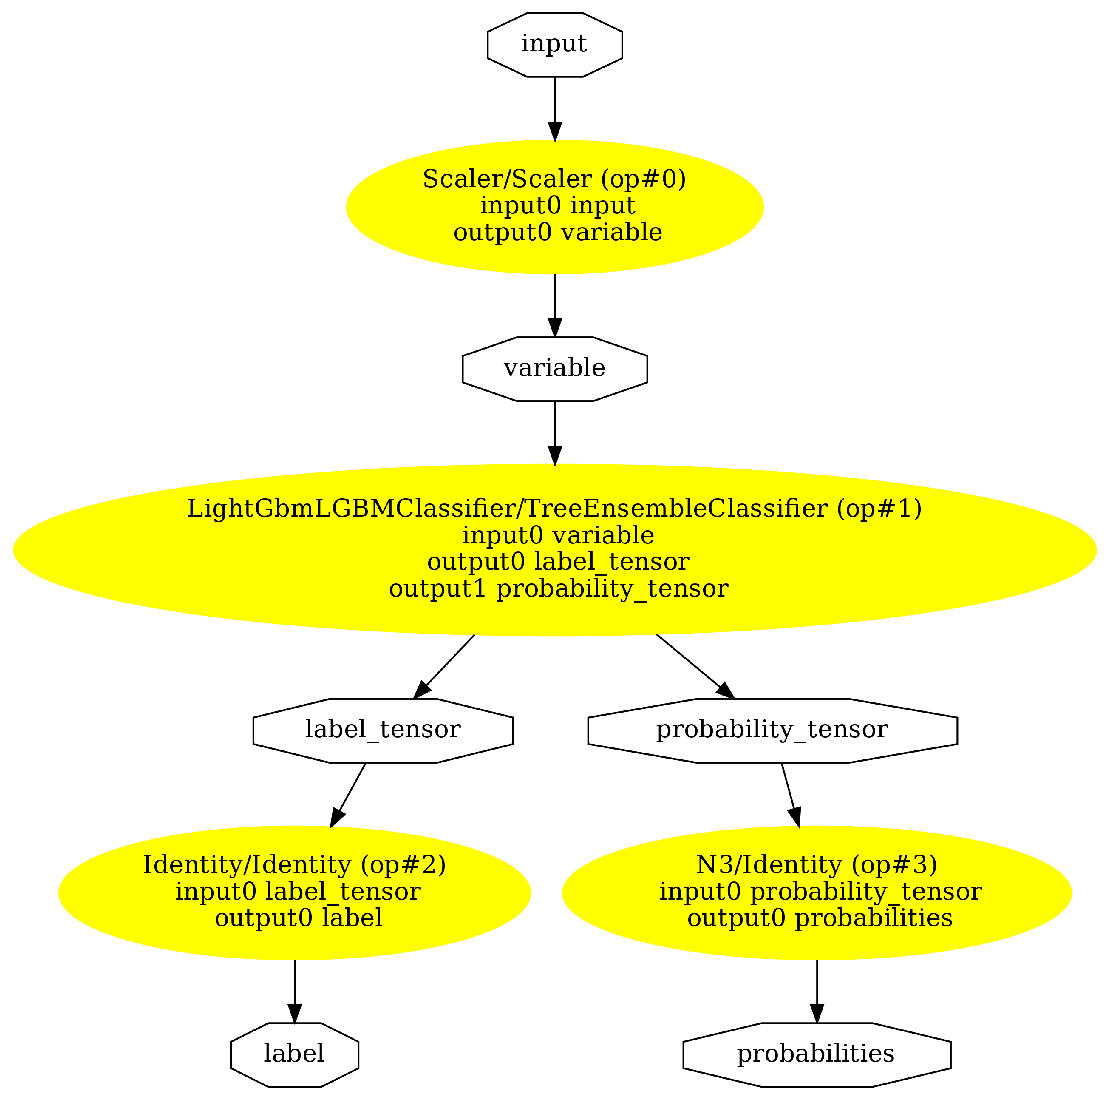

In [7]:
pydot_graph = GetPydotGraph(
    model_onnx.graph, name=model_onnx.graph.name, rankdir="TB",
    node_producer=GetOpNodeProducer(
        "docstring", color="yellow",
        fillcolor="yellow", style="filled"))
pydot_graph.write_dot("pipeline.dot")

os.system('dot -O -Gdpi=300 -Tpng pipeline.dot')

image = plt.imread("pipeline.dot.png")
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(image)
ax.axis('off')

**Versions used for this example**



In [8]:
print("numpy:", numpy.__version__)
print("scikit-learn:", sklearn.__version__)
print("onnx: ", onnx.__version__)
print("onnxruntime: ", onnxruntime.__version__)
print("skl2onnx: ", skl2onnx.__version__)
print("onnxmltools: ", onnxmltools.__version__)
print("lightgbm: ", lightgbm.__version__)

numpy: 1.18.1
scikit-learn: 0.22.1
onnx:  1.6.0
onnxruntime:  1.1.0
skl2onnx:  1.6.0
onnxmltools:  1.6.0
lightgbm:  2.3.1
